In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
# from sklearn.svm import SVR
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
import time

In [177]:
X_data = pd.read_csv('./Data/X_train.csv')
X_test_final = pd.read_csv('./Data/X_test.csv')
y_data = pd.read_csv('./Data/y_train.csv')
data = X_data.merge(y_data, on='id')
data['label'] = data['label'].replace(-1, 0)
print(f"There are {data.shape[1]} columns and {data.shape[0]} rows")
data.head(10)

There are 439 columns and 48000 rows


,id,year,fw_start,fw_end,country,c_abrv,v1,v2,v3,v4,...,v278c_r,v279a,v279b,v279c_r,v279d_r,v280,v281a,v281a_r,v282,label
0,0,2020,202011,202011,804,UA,2,1,2,2,...,14.45,15,40,15.40,55,1,uk,475,32,2
1,1,2018,201809,201811,688,RS,2,1,2,2,...,17.12,18,25,18.25,73,2,sr,397,3,2
2,2,2017,201706,201803,352,IS,2,2,1,1,...,15.58,13,20,13.20,-5,2,is,72,87,4
3,3,2021,202105,202110,428,LV,1,2,1,1,...,8.42,8,51,8.51,9,1,lv,256,5157,3
4,4,2018,201801,201805,40,AT,1,1,2,2,...,12.51,13,53,13.53,62,1,de,158,64,3
5,5,2018,201802,201808,348,HU,1,1,1,1,...,8.11,8,46,8.46,35,2,hu,184,13,3
6,6,2017,201711,201801,724,ES,2,1,1,2,...,17.39,18,21,18.21,42,1,es,426,426,3
7,7,2019,201902,201906,70,BA,1,1,2,2,...,10.25,10,54,10.54,29,1,bs,65,93,1
8,8,2017,201709,201712,703,SK,1,1,3,1,...,21.17,22,7,22.07,50,2,sk,415,66,1
9,9,2017,201710,201802,191,HR,1,1,2,2,...,16.50,17,38,17.38,48,1,hr,90,51038,3


In [213]:
## Helper functions
def get_col_name_exc(colnames, v, ex):
    ex_col = v + '_' + ex
    result = [col for col in colnames if v in col and col != ex_col]
    return result

def cond(string):
    if (string[0] == '-') or string.isdigit():
        if (int(string) < 0):
            return np.NaN
    return string

## Df manipulating functions

def drop_cols1(df, verbose=True):
    ## Columns with only one value
    drop_one_val_col = list(df.columns[df.nunique() == 1])
    
    ## Specific columns
    drop_v243 = get_col_name_exc(df.columns, 'v243', 'r')
    drop_v252 = get_col_name_exc(df.columns, 'v252', 'r')
    drop_v262 = get_col_name_exc(df.columns, 'v262', 'r')
    drop_v263 = get_col_name_exc(df.columns, 'v263', 'r')
    misc = ['country', 'id']
    
    # Concat
    col_name_drop = drop_v243 + drop_v252 + drop_v262 + drop_v263 + drop_one_val_col + misc
    if verbose:
        print(f"Dropped {len(col_name_drop)} columns")
        print(f"Dropped columns {col_name_drop}")
    return df.drop(col_name_drop, axis=1)
def merge_cols(df, code_ls, verbose):
    for code in code_ls:
        cols = [col for col in df.columns if code in col]
        if verbose:
            print(f"Dropping {len(cols)} columns")
            print(f"Columns dropped {cols}")
        for col in cols:
            # print(f"{col}")
            stem = col[:-len(code) - 1]
            # print(f"{stem}")
            df.loc[df[stem] == -4, stem] = df.loc[df[stem] == -4, col]
            df.drop(col, inplace=True, axis=1)
    return df



def replace_negative_with_zero(df):
    # For number columns
    for col in df.columns[df.dtypes != object]:
        df[col] = df[col].apply(lambda x: max(x, 0))
        
    # For object columns
    df[df.columns[df.dtypes == object]] = df[df.columns[df.dtypes == object]].applymap(lambda x: cond(x))
    return df


def drop_similar(df, verbose=True):
    col_df = pd.DataFrame(df.columns.tolist(), columns=['Colname'])
    col_df['cols'] = col_df['Colname'].apply(lambda x: x.split('_')[0])
    col_df_grouped = col_df.groupby('cols', as_index=False).count()
    cols_keep = col_df[col_df['cols'].isin(list(col_df_grouped[col_df_grouped['Colname'] > 1]['cols'])) & col_df['cols'].apply(lambda x: x[:1] == 'v')].groupby('cols', as_index=False)['Colname'].first().Colname.tolist()
    cols_keep.remove('v275b_N2')
    cols_keep.remove('v275c_N2')
    cols_keep += ['age', 'fw_start', 'fw_end', 'v275b_N1', 'v275c_N1']
    cols_remove = col_df[col_df['cols'].isin(list(col_df_grouped[col_df_grouped['Colname'] > 1]['cols'])) & ~col_df['Colname'].isin(cols_keep)].Colname.tolist()
    if verbose:
        print(f"Dropped {len(cols_remove)} columns")
        print(f"Columns dropped {cols_remove}")
    return df.drop(cols_remove, axis=1)

def clean_data(df, verbose=True):
    code_ls = ['DK', '11c']
    
    # Dropping columns with 1 value
    if verbose:
        print("Dropping columns with 1 value")
    df = drop_cols1(df, verbose)
    
    # Merging columns with specific modifications i.e. DK, 11c
    if verbose:
        print("\nMerging columns with specific mods")
    df = merge_cols(df, code_ls, verbose)
    
    # Replacing negative values with 0 for both object and numeric column types
    if verbose:
        print("\nReplacing negative values with 0")
    df = replace_negative_with_zero(df)
    
    # Dropping similar VXXX columns that conveys the same thing
    if verbose:
        print("\nDropping similar columns")
    df = drop_similar(df, verbose)
    
    # One hot-encode object columns
    if verbose:
        print("\nOne hot encoding")
    df = pd.get_dummies(df)
    return df

def get_final_df(df_train, df_test, verbose=True):
    start = time.time()
    X_train_clean = clean_data(df_train, verbose)
    X_test_clean = clean_data(df_test, verbose)
    
    col_test_to_add = X_train_clean.columns[~X_train_clean.columns.isin(X_test_clean.columns)]
    for col in col_test_to_add:
        X_test_clean[col] = 0

    col_train_to_add =  X_test_clean.columns[~X_test_clean.columns.isin(X_train_clean.columns)]
    for col in col_train_to_add:
        X_train_clean[col] = 0
    end = time.time()
    print(f"Time elapsed: {end - start} sec")
    return X_train_clean, X_test_clean
    
X_train_clean = clean_data(data, verbose=False)
X_test_clean = clean_data(X_test_final, verbose=False)

final_train_df, final_test_df = get_final_df(data, X_test_final, verbose=False)
# if (smth_df == final_df).all().all():
#     print("The two DataFrames are equal")
# else:
#     print("The two DataFrames are not equal")

Time elapsed: 11.79550814628601 sec


(48000, 1310)

In [214]:
final_test_df['label']

0        0
1        0
2        0
3        0
4        0
        ..
11433    0
11434    0
11435    0
11436    0
11437    0
Name: label, Length: 11438, dtype: int64

In [206]:
final_train_df.columns[~final_train_df.columns.isin(final_test_df.columns)]

Index([], dtype='object')

In [207]:
final_test_df.columns[~final_test_df.columns.isin(final_train_df.columns)]

Index([], dtype='object')

# Data Wrangling
## Step 1: Drop
### a) Columns with only one value
### b) Specific columns

In [144]:
# To drop
dropped_df = drop_cols1(data.copy())
dropped_df.head()

Dropped 74 columns
Dropped columns ['v243_edulvlb', 'v243_edulvlb_2', 'v243_edulvlb_1', 'v243_ISCED_3', 'v243_ISCED_2', 'v243_ISCED_2b', 'v243_ISCED_1', 'v243_EISCED', 'v243_ISCED97', 'v243_8cat', 'v243_cs', 'v243_cs_DE1', 'v243_cs_DE2', 'v243_cs_DE3', 'v243_cs_GB1', 'v243_cs_GB2', 'v252_edulvlb', 'v252_edulvlb_2', 'v252_edulvlb_1', 'v252_ISCED_3', 'v252_ISCED_2', 'v252_ISCED_2b', 'v252_ISCED_1', 'v252_EISCED', 'v252_ISCED97', 'v252_8cat', 'v252_cs', 'v252_cs_DE1', 'v252_cs_DE2', 'v252_cs_DE3', 'v252_cs_GB1', 'v252_cs_GB2', 'v262_edulvlb', 'v262_edulvlb_2', 'v262_edulvlb_1', 'v262_ISCED_3', 'v262_ISCED_2', 'v262_ISCED_2b', 'v262_ISCED_1', 'v262_EISCED', 'v262_ISCED97', 'v262_8cat', 'v262_cs', 'v262_cs_DE1', 'v262_cs_DE2', 'v262_cs_DE3', 'v262_cs_GB1', 'v262_cs_GB2', 'v263_edulvlb', 'v263_edulvlb_2', 'v263_edulvlb_1', 'v263_ISCED_3', 'v263_ISCED_2', 'v263_ISCED_2b', 'v263_ISCED_1', 'v263_EISCED', 'v263_ISCED97', 'v263_8cat', 'v263_cs', 'v263_cs_DE1', 'v263_cs_DE2', 'v263_cs_DE3', 'v263_

,year,fw_start,fw_end,c_abrv,v1,v2,v3,v4,v5,v7,...,v278c_r,v279a,v279b,v279c_r,v279d_r,v280,v281a,v281a_r,v282,label
0,2020,202011,202011,UA,2,1,2,2,3,2,...,14.45,15,40,15.40,55,1,uk,475,32,2
1,2018,201809,201811,RS,2,1,2,2,3,2,...,17.12,18,25,18.25,73,2,sr,397,3,2
2,2017,201706,201803,IS,2,2,1,1,2,2,...,15.58,13,20,13.20,-5,2,is,72,87,4
3,2021,202105,202110,LV,1,2,1,1,2,2,...,8.42,8,51,8.51,9,1,lv,256,5157,3
4,2018,201801,201805,AT,1,1,2,2,3,2,...,12.51,13,53,13.53,62,1,de,158,64,3


## Step 2: Modify
### a) Merge columns with specific country differences. i.e. DK

In [145]:
# To modify
## To merge
merged_df = merge_cols(dropped_df.copy(), code_ls)
# # To check
# test.loc[dropped_df['v176'] == -4, [col[:-3] for col in dropped_df.columns if code in col]]
# test.loc[dropped_df['v176'] == -4, [col[:-3] for col in dropped_df.columns if code in col]]
merged_df

Dropping 12 columns
Columns dropped ['v176_DK', 'v177_DK', 'v178_DK', 'v179_DK', 'v180_DK', 'v181_DK', 'v182_DK', 'v183_DK', 'v221_DK', 'v222_DK', 'v223_DK', 'v224_DK']
Dropping 9 columns
Columns dropped ['v133_11c', 'v134_11c', 'v135_11c', 'v136_11c', 'v137_11c', 'v138_11c', 'v139_11c', 'v140_11c', 'v141_11c']


,year,fw_start,fw_end,c_abrv,v1,v2,v3,v4,v5,v7,...,v278c_r,v279a,v279b,v279c_r,v279d_r,v280,v281a,v281a_r,v282,label
0,2020,202011,202011,UA,2,1,2,2,3,2,...,14.45,15,40,15.40,55,1,uk,475,32,2
1,2018,201809,201811,RS,2,1,2,2,3,2,...,17.12,18,25,18.25,73,2,sr,397,3,2
2,2017,201706,201803,IS,2,2,1,1,2,2,...,15.58,13,20,13.20,-5,2,is,72,87,4
3,2021,202105,202110,LV,1,2,1,1,2,2,...,8.42,8,51,8.51,9,1,lv,256,5157,3
4,2018,201801,201805,AT,1,1,2,2,3,2,...,12.51,13,53,13.53,62,1,de,158,64,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,2019,201812,201903,MK,1,1,1,2,2,1,...,14.10,14,48,14.48,38,1,mk,279,1,2
47996,2018,201808,201812,NO,1,1,1,2,2,1,...,15.20,16,45,16.45,85,1,no,200,1302,1
47997,2018,201802,201807,AL,2,1,1,2,4,1,...,13.40,14,20,14.20,40,1,sq,13,10,4
47998,2017,201709,201801,DK,2,1,2,2,3,1,...,-4.00,-4,-4,-4.00,-4,-4,da,32,-4,4


### b) Modify negative values to 0 for number columns and np.NaN for object columns

In [147]:
non_neg_df = replace_negative_with_zero(merged_df.copy())
non_neg_df.head(10)

,year,fw_start,fw_end,c_abrv,v1,v2,v3,v4,v5,v7,...,v278c_r,v279a,v279b,v279c_r,v279d_r,v280,v281a,v281a_r,v282,label
0,2020,202011,202011,UA,2,1,2,2,3,2,...,14.45,15,40,15.40,55,1,uk,475,32,2
1,2018,201809,201811,RS,2,1,2,2,3,2,...,17.12,18,25,18.25,73,2,sr,397,3,2
2,2017,201706,201803,IS,2,2,1,1,2,2,...,15.58,13,20,13.20,0,2,is,72,87,4
3,2021,202105,202110,LV,1,2,1,1,2,2,...,8.42,8,51,8.51,9,1,lv,256,5157,3
4,2018,201801,201805,AT,1,1,2,2,3,2,...,12.51,13,53,13.53,62,1,de,158,64,3
5,2018,201802,201808,HU,1,1,1,1,2,1,...,8.11,8,46,8.46,35,2,hu,184,13,3
6,2017,201711,201801,ES,2,1,1,2,3,1,...,17.39,18,21,18.21,42,1,es,426,426,3
7,2019,201902,201906,BA,1,1,2,2,4,2,...,10.25,10,54,10.54,29,1,bs,65,93,1
8,2017,201709,201712,SK,1,1,3,1,3,1,...,21.17,22,7,22.07,50,2,sk,415,66,1
9,2017,201710,201802,HR,1,1,2,2,3,3,...,16.50,17,38,17.38,48,1,hr,90,51038,3


### Drop similar VXXX columns.

In [149]:
def drop_similar(df):
    col_df = pd.DataFrame(df.columns.tolist(), columns=['Colname'])
    col_df['cols'] = col_df['Colname'].apply(lambda x: x.split('_')[0])
    col_df_grouped = col_df.groupby('cols', as_index=False).count()
    cols_keep = col_df[col_df['cols'].isin(list(col_df_grouped[col_df_grouped['Colname'] > 1]['cols'])) & col_df['cols'].apply(lambda x: x[:1] == 'v')].groupby('cols', as_index=False)['Colname'].first().Colname.tolist()
    cols_keep.remove('v275b_N2')
    cols_keep.remove('v275c_N2')
    cols_keep += ['age', 'fw_start', 'fw_end', 'v275b_N1', 'v275c_N1']
    cols_remove = col_df[col_df['cols'].isin(list(col_df_grouped[col_df_grouped['Colname'] > 1]['cols'])) & ~col_df['Colname'].isin(cols_keep)].Colname.tolist()
    print(f"Dropped {len(cols_remove)} columns")
    print(cols_remove)
    return df.drop(cols_remove, axis=1)
dropped_v2 = drop_similar(non_neg_df)
dropped_v2.head(10)

Dropped 25 columns
['v52_cs', 'v111_4', 'v174_cs', 'v175_cs', 'age_r', 'age_r2', 'age_r3', 'v228b_r', 'v231b_r', 'v233b_r', 'v242_r', 'v246_SIOPS', 'v246_ISEI', 'v246_ESeC', 'v246_egp', 'v251b_r', 'v255_SIOPS', 'v255_ISEI', 'v255_ESeC', 'v255_egp', 'v261_ppp', 'v261_r', 'v275b_N2', 'v275c_N2', 'v281a_r']


,year,fw_start,fw_end,c_abrv,v1,v2,v3,v4,v5,v7,...,v278b,v278c_r,v279a,v279b,v279c_r,v279d_r,v280,v281a,v282,label
0,2020,202011,202011,UA,2,1,2,2,3,2,...,45,14.45,15,40,15.40,55,1,uk,32,2
1,2018,201809,201811,RS,2,1,2,2,3,2,...,12,17.12,18,25,18.25,73,2,sr,3,2
2,2017,201706,201803,IS,2,2,1,1,2,2,...,58,15.58,13,20,13.20,0,2,is,87,4
3,2021,202105,202110,LV,1,2,1,1,2,2,...,42,8.42,8,51,8.51,9,1,lv,5157,3
4,2018,201801,201805,AT,1,1,2,2,3,2,...,51,12.51,13,53,13.53,62,1,de,64,3
5,2018,201802,201808,HU,1,1,1,1,2,1,...,11,8.11,8,46,8.46,35,2,hu,13,3
6,2017,201711,201801,ES,2,1,1,2,3,1,...,39,17.39,18,21,18.21,42,1,es,426,3
7,2019,201902,201906,BA,1,1,2,2,4,2,...,25,10.25,10,54,10.54,29,1,bs,93,1
8,2017,201709,201712,SK,1,1,3,1,3,1,...,17,21.17,22,7,22.07,50,2,sk,66,1
9,2017,201710,201802,HR,1,1,2,2,3,3,...,50,16.50,17,38,17.38,48,1,hr,51038,3


### c) One-hot encode all object type columns

In [150]:
dropped_v2[dropped_v2.columns[dropped_v2.dtypes == object]]
final_df = pd.get_dummies(dropped_v2)
final_df.head(10)

,year,fw_start,fw_end,v1,v2,v3,v4,v5,v7,v8,...,v281a_no,v281a_pl,v281a_pt,v281a_ro,v281a_ru,v281a_sk,v281a_sl,v281a_sq,v281a_sr,v281a_uk
0,2020,202011,202011,2,1,2,2,3,2,3,...,0,0,0,0,0,0,0,0,0,1
1,2018,201809,201811,2,1,2,2,3,2,2,...,0,0,0,0,0,0,0,0,1,0
2,2017,201706,201803,2,2,1,1,2,2,1,...,0,0,0,0,0,0,0,0,0,0
3,2021,202105,202110,1,2,1,1,2,2,3,...,0,0,0,0,0,0,0,0,0,0
4,2018,201801,201805,1,1,2,2,3,2,1,...,0,0,0,0,0,0,0,0,0,0
5,2018,201802,201808,1,1,1,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
6,2017,201711,201801,2,1,1,2,3,1,1,...,0,0,0,0,0,0,0,0,0,0
7,2019,201902,201906,1,1,2,2,4,2,3,...,0,0,0,0,0,0,0,0,0,0
8,2017,201709,201712,1,1,3,1,3,1,2,...,0,0,0,0,0,1,0,0,0,0
9,2017,201710,201802,1,1,2,2,3,3,3,...,0,0,0,0,0,0,0,0,0,0


In [196]:
final_train_df.dtypes

id           int64
year         int64
fw_start     int64
fw_end       int64
country      int64
             ...  
v280         int64
v281a       object
v281a_r      int64
v282         int64
label        int64
Length: 439, dtype: object

# Modeling

In [268]:
RANDOM_STATE = 2024
X_train, X_test, y_train, y_test = train_test_split(final_train_df.drop('label', axis=1), final_train_df['label'], test_size=0.2, random_state=RANDOM_STATE)

In [219]:
X_train

,year,fw_start,fw_end,v1,v2,v3,v4,v5,v7,v8,...,v251b_DM,v251b_GA,v251b_MT,v275b_N1_ME0,v275b_N1_SE1,v275b_N1_SE2,v275b_N1_SE3,v281a_cnr,v281a_eu,v281a_sv
37584,2018,201802,201803,1,1,3,2,4,1,3,...,0,0,0,0,0,0,0,0,0,0
14459,2018,201801,201805,2,1,1,2,3,2,1,...,0,0,0,0,0,0,0,0,0,0
34360,2018,201808,201812,1,1,2,2,1,2,1,...,0,0,0,0,0,0,0,0,0,0
30515,2018,201802,201807,1,1,1,2,1,2,2,...,0,0,0,0,0,0,0,0,0,0
47333,2018,201803,201805,1,1,2,2,2,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,2017,201706,201803,0,1,2,2,3,1,4,...,0,0,0,0,0,0,0,0,0,0
30244,2018,201802,201807,3,1,2,1,3,1,1,...,0,0,0,0,0,0,0,0,0,0
47643,2017,201711,201802,1,1,2,2,3,4,4,...,0,0,0,0,0,0,0,0,0,0
35456,2020,202001,202003,2,2,2,2,4,2,1,...,0,0,0,0,0,0,0,0,0,0


## XGboost

In [218]:
start = time.time()
test_params = {
    'max_depth':np.array([6, 8, 10]),
 # 'eta': np.array([0.001, 0.01, 0.1])
    'eta': np.array([0.1])
}

model = GridSearchCV(
    estimator = xgb.XGBClassifier(objective='multi:softprob', 
                                  subsample=0.5, eval_metric='logloss'), 
    param_grid = test_params)
model.fit(X_train,y_train)
end = time.time()
print(f'The combination of parameters that minimizes classification error is {model.best_params_}')
print("The time of execution of above program is :",
      round(end-start, 4), "s")

The combination of parameters that minimizes classification error is {'eta': 0.1, 'max_depth': 6}
The time of execution of above program is : 358.092 s


In [220]:
pd.DataFrame(model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,18.156304,1.041114,0.297477,0.059342,0.1,6,"{'eta': 0.1, 'max_depth': 6}",0.632552,0.642578,0.636458,0.635677,0.639193,0.637292,0.003386,1
1,20.925860,0.997240,0.268089,0.006741,0.1,8,"{'eta': 0.1, 'max_depth': 8}",0.628125,0.639583,0.635286,0.632812,0.637891,0.634740,0.004029,2
2,27.950416,2.592117,0.302952,0.035381,0.1,10,"{'eta': 0.1, 'max_depth': 10}",0.626042,0.639583,0.638151,0.633203,0.628385,0.633073,0.005284,3


In [253]:
params = {
    'objective':'multi:softprob',
    'max_depth': model.best_params_['max_depth'],
    'subsample':0.5,
    'eta': model.best_params_['eta'],
    'eval_metric':'logloss'
}     
# instantiate the classifier 
xgb_model = xgb.XGBClassifier(**params, verbosity=2)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict_proba(X_test)
print("Logloss on test data:", round(log_loss(y_test, y_pred), 4))

Logloss on test data: 0.8506


In [254]:
y_pred = model.predict_proba(X_test)
print("Logloss on test data:", round(log_loss(y_test, y_pred), 4))

Logloss on test data: 0.8506


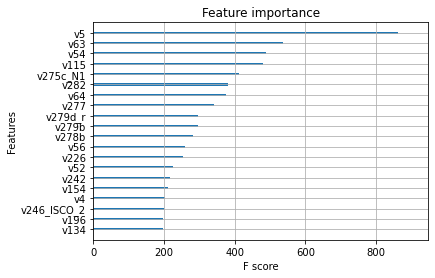

In [262]:
xgb.plot_importance(xgb_model, show_values=False, max_num_features=20)
plt.show()

### Without data cleaning

In [270]:
data_unclean = pd.get_dummies(data)
Xu_train, Xu_test, yu_train, yu_test = train_test_split(data_unclean.drop(['id','label'], axis=1), data_unclean['label'], test_size=0.2, random_state=RANDOM_STATE)

Logloss on test data: 0.853


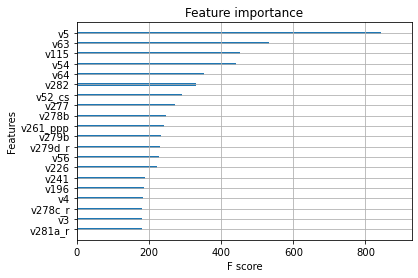

In [271]:
params = {
    'objective':'multi:softprob',
    'max_depth': model.best_params_['max_depth'],
    'subsample':0.5,
    'eta': model.best_params_['eta'],
    'eval_metric':'logloss'
}     
# instantiate the classifier 
xgbu_model = xgb.XGBClassifier(**params, verbosity=2)
xgbu_model.fit(Xu_train, yu_train)
yu_pred = xgbu_model.predict_proba(Xu_test)
print("Logloss on test data:", round(log_loss(yu_test, yu_pred), 4))
xgb.plot_importance(xgbu_model, show_values=False, max_num_features=20)
plt.show()

## Logistic Regression

In [232]:
from sklearn.linear_model import LogisticRegression

start = time.time()
# Obtained from GridSearch
lg_params = {'C': 0.1, 'multi_class': 'multinomial', 'penalty': 'l1'}

lg_model = LogisticRegression(
    max_iter=2000,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    solver='saga',
    **lg_params
)
lg_model.fit(X_train, y_train)
end = time.time()
print("The time of execution of above program is :", round(end-start, 4), "s")

/Users/alexandermichaeltjhin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


KeyboardInterrupt: 

## SVM

In [ ]:
# Fit on SVM Linear
from sklearn.svm import SVC

# svm_params = {'C': 1, 'kernel': 'rbf'}

# svm_model = SVC(
#     probability=True,
#     random_state=RANDOM_STATE,
#     **svm_params
# )

start = time.time()
test_params = {
    'C':np.array([1, 0.1, 0.01]),
 # 'eta': np.array([0.001, 0.01, 0.1])
    'gamma': np.array(["scale", "auto"]),
    'decision_function_shape': np.array([])
}

svm_model = GridSearchCV(
    estimator = SVC(probability=True, random_state=RANDOM_STATE), 
    param_grid = test_params
)

end = time.time()
print(f'The combination of parameters that minimizes classification error is {svm_model.best_params_}')
print("The time of execution of above program is :",
      round(end-start, 4), "s")

## Naive Bayes

In [241]:
from sklearn.naive_bayes import MultinomialNB
MultNB_model = MultinomialNB()
MultNB_model.fit(X_train, y_train)
MultNB_y_pred = MultNB_model.predict_proba(X_test)
print("Logloss on test data:", round(log_loss(y_test, MultNB_y_pred), 4))

Logloss on test data: 33.7509


In [242]:
from sklearn.naive_bayes import GaussianNB
GausNB_model = GaussianNB()
GausNB_model.fit(X_train, y_train)
GausNB_y_pred = GausNB_model.predict_proba(X_test)
print("Logloss on test data:", round(log_loss(y_test, GausNB_y_pred), 4))

Logloss on test data: 1.7295


/Users/alexandermichaeltjhin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Stacking

In [ ]:
param = {
        'name': '(SVM + LR + XGB) + Logistic Regression',
        'estimators': [
            ('Logistic Regression L1', lg_model),
            ('XG Boost', model),
            ('SVM', svm_model)
        ],
        'final': LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
        'additional': {}
}

stack_model = StackingClassifier(
    estimators=param['estimators'],
    final_estimator=param['final'],
    cv=5,
    n_jobs=-1,
    **param['additional']
)

stack_model.fit(X, y)
val_preds = stack_model.predict_proba(val.drop(columns=['output']))
loss = log_loss(val['output'], val_preds)
print(f"{param['name']} LOSS:", loss)

test_preds = stack_model.predict_proba(test.drop(columns=['output']))

# Save predictions
# PRED_PATH = f'/kaggle/working/predictions{i}.csv'
# columns = ['no answer','very important','quite important','not important','not at all important']
# preds_df = pd.DataFrame(test_preds, columns=columns)
# preds_df.to_csv(PRED_PATH, index=True, index_label='id')